# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                      
Sample_012  Q96SM3                                 17.192
Sample_090  Q9UM22                                 17.017
Sample_135  A6XND0;A6XND1;B3KWK7;P17936;P17936-2   16.950
Sample_026  O95450;O95450-2                        15.008
Sample_073  O94910;O94910-2                        16.943
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups        
Sample_150  O60512                   11.170
Sample_068  H0Y7T8;P49418;P49418-2   13.302
Sample_012  A0A075B6J9               16.396
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.651
            A0A075B6Q5                 12.261
            A0A075B6R2                 12.338
            A0A075B6S5                 12.700
            A0A087WSY4                 12.024
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.186
            Q9UI40;Q9UI40-2            11.748
            Q9UIW2                     12.477
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.276
            Q9UP79                     12.536
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.752,15.050,16.842,19.863,15.917,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,17.106,19.067,...,15.528,15.576,14.119,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.850,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.013,17.705,17.039,15.789,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.764,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.943,15.345,17.084,18.708,14.249,19.433,10.785,10.429
Sample_207,15.739,16.877,15.469,16.898,14.071,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,14.651,...,16.012,15.178,11.789,15.050,16.842,19.863,14.649,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,14.032,19.067,16.188,...,15.528,15.576,13.871,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.222,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,11.946,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.837,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.200,15.345,17.084,18.708,14.249,19.433,11.965,13.075
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 367.89it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.80it/s]

100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.75it/s]

100%|██████████| 3/3 [00:00<00:00,  3.08it/s]

100%|██████████| 3/3 [00:00<00:00,  3.17it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.23it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.37it/s]

100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.91it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.59it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.24it/s]

100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.68it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.80it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.71it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.68it/s]

100%|██████████| 6/6 [00:02<00:00,  2.72it/s]

100%|██████████| 6/6 [00:02<00:00,  2.77it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.34it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.47it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.40it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.34it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.36it/s]

100%|██████████| 7/7 [00:02<00:00,  2.33it/s]

100%|██████████| 7/7 [00:02<00:00,  2.41it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.79it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.78it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.58it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.52it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.60it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.63it/s]

100%|██████████| 8/8 [00:02<00:00,  2.78it/s]

100%|██████████| 8/8 [00:02<00:00,  2.74it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.98it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.60it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.30it/s]

 56%|█████▌    | 5/9 [00:02<00:02,  1.98it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.94it/s]

 78%|███████▊  | 7/9 [00:03<00:00,  2.04it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.28it/s]

100%|██████████| 9/9 [00:03<00:00,  2.39it/s]

100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.55it/s]

 30%|███       | 3/10 [00:00<00:02,  3.31it/s]

 40%|████      | 4/10 [00:01<00:01,  3.06it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.87it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.98it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.96it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.02it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.93it/s]

100%|██████████| 10/10 [00:03<00:00,  2.92it/s]

100%|██████████| 10/10 [00:03<00:00,  3.00it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.03it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.67it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.25it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.97it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.89it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.82it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.65it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.40it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.12it/s]

100%|██████████| 11/11 [00:04<00:00,  1.91it/s]

100%|██████████| 11/11 [00:04<00:00,  2.48it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.40it/s]

 25%|██▌       | 3/12 [00:00<00:03,  2.92it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.29it/s]

 42%|████▏     | 5/12 [00:02<00:03,  2.14it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.21it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.18it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.16it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.25it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.28it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.26it/s]

100%|██████████| 12/12 [00:05<00:00,  2.47it/s]

100%|██████████| 12/12 [00:05<00:00,  2.39it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  3.59it/s]

 23%|██▎       | 3/13 [00:01<00:03,  2.69it/s]

 31%|███       | 4/13 [00:01<00:03,  2.54it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.32it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.38it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.55it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.43it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.49it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.54it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.57it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.79it/s]

100%|██████████| 13/13 [00:04<00:00,  2.94it/s]

100%|██████████| 13/13 [00:04<00:00,  2.65it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.11it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.53it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.05it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.72it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.81it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.78it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.77it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.72it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.77it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.82it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.97it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.99it/s]

100%|██████████| 14/14 [00:04<00:00,  3.09it/s]

100%|██████████| 14/14 [00:04<00:00,  2.98it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.68it/s]

 20%|██        | 3/15 [00:00<00:03,  3.42it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.24it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.06it/s]

 40%|████      | 6/15 [00:01<00:02,  3.08it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.86it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.81it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.81it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.73it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.70it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.60it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.50it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.31it/s]

100%|██████████| 15/15 [00:05<00:00,  2.22it/s]

100%|██████████| 15/15 [00:05<00:00,  2.66it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.049 0.008          0.736 0.369       0.109   
2             0.004 0.002      0.061 0.021          0.758 0.090       0.709   
3             0.004 0.000      0.050 0.015          0.755 0.088       0.712   
4             0.004 0.003      0.056 0.018          0.789 0.097       0.778   
5             0.006 0.004      0.058 0.017          0.779 0.088       0.778   
6             0.004 0.003      0.050 0.013          0.782 0.089       0.793   
7             0.004 0.002      0.054 0.016          0.839 0.082       0.819   
8             0.005 0.004      0.067 0.026          0.842 0.076       0.821   
9             0.004 0.002      0.050 0.015          0.833 0.074       0.819   
10            0.007 0.006      0.064 0.022          0.828 0.072       0.812   
11            0.005 0.003      0.055 0.018          0.828 0.075       0.808   
12            0.004 0.002      0.049 0.012          0.823 0.075       0.809   
13            0.006 0.005      0.072 0.033          0.823 0.075       0.807   
14            0.007 0.007      0.085 0.052          0.819 0.087       0.811   
15            0.006 0.005      0.065 0.028          0.817 0.089       0.810   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.084   0.182 0.129                  0.547 0.040        0.855   
2          0.092   0.726 0.060                  0.768 0.048        0.856   
3          0.087   0.728 0.066                  0.769 0.053        0.857   
4          0.095   0.779 0.072                  0.810 0.062        0.894   
5          0.091   0.774 0.065                  0.806 0.056        0.898   
6          0.096   0.783 0.071                  0.814 0.062        0.897   
7          0.101   0.824 0.071                  0.850 0.060        0.912   
8          0.102   0.827 0.069                  0.853 0.058        0.911   
9          0.093   0.822 0.065                  0.848 0.055        0.912   
10         0.099   0.817 0.069                  0.844 0.057        0.910   
11         0.098   0.815 0.070                  0.842 0.058        0.910   
12         0.096   0.813 0.069                  0.840 0.057        0.908   
13         0.094   0.811 0.066                  0.839 0.055        0.907   
14         0.095   0.811 0.070                  0.838 0.060        0.909   
15         0.097   0.809 0.071                  0.836 0.060        0.907   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.825 0.089        210.000 0.000  
2          0.060                  0.833 0.067        210.000 0.000  
3          0.059                  0.839 0.066        210.000 0.000  
4          0.053                  0.878 0.060        210.000 0.000  
5          0.049                  0.883 0.052        210.000 0.000  
6          0.050                  0.882 0.054        210.000 0.000  
7          0.053                  0.898 0.056        210.000 0.000  
8          0.053                  0.898 0.057        210.000 0.000  
9          0.053                  0.900 0.056        210.000 0.000  
10         0.054                  0.898 0.056        210.000 0.000  
11         0.055                  0.897 0.058        210.000 0.000  
12         0.055                  0.895 0.059        210.000 0.000  
13         0.056                  0.892 0.060        210.000 0.000  
14         0.054                  0.898 0.056        210.000 0.000  
15         0.053                  0.895 0.055 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 428.25it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.70it/s]

100%|██████████| 3/3 [00:00<00:00,  4.27it/s]

100%|██████████| 3/3 [00:00<00:00,  4.48it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.30it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.62it/s]

100%|██████████| 4/4 [00:01<00:00,  2.97it/s]

100%|██████████| 4/4 [00:01<00:00,  3.29it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.64it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.27it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.71it/s]

100%|██████████| 5/5 [00:01<00:00,  2.62it/s]

100%|██████████| 5/5 [00:01<00:00,  2.80it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.43it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.91it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.11it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.69it/s]

100%|██████████| 6/6 [00:01<00:00,  3.47it/s]

100%|██████████| 6/6 [00:01<00:00,  3.90it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.29it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.28it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.59it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.50it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.49it/s]

100%|██████████| 7/7 [00:02<00:00,  2.58it/s]

100%|██████████| 7/7 [00:02<00:00,  2.71it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.87it/s]

 38%|███▊      | 3/8 [00:00<00:01,  2.84it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.57it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.54it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.50it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.38it/s]

100%|██████████| 8/8 [00:03<00:00,  2.31it/s]

100%|██████████| 8/8 [00:03<00:00,  2.51it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.15it/s]

 33%|███▎      | 3/9 [00:00<00:02,  2.91it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.92it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.87it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.86it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.90it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.94it/s]

100%|██████████| 9/9 [00:03<00:00,  2.89it/s]

100%|██████████| 9/9 [00:03<00:00,  2.95it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.51it/s]

 30%|███       | 3/10 [00:00<00:02,  3.48it/s]

 40%|████      | 4/10 [00:01<00:02,  2.89it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.81it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.77it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.70it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.71it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.45it/s]

100%|██████████| 10/10 [00:03<00:00,  2.47it/s]

100%|██████████| 10/10 [00:03<00:00,  2.73it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.53it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.22it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.85it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.82it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.81it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.70it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.74it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.46it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.56it/s]

100%|██████████| 11/11 [00:04<00:00,  2.57it/s]

100%|██████████| 11/11 [00:04<00:00,  2.74it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.60it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.23it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.88it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.70it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.83it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.85it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.51it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.58it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.62it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.67it/s]

100%|██████████| 12/12 [00:04<00:00,  2.76it/s]

100%|██████████| 12/12 [00:04<00:00,  2.80it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.67it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.29it/s]

 31%|███       | 4/13 [00:01<00:03,  2.88it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.64it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.55it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.48it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.53it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.61it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.70it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.73it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.77it/s]

100%|██████████| 13/13 [00:04<00:00,  2.71it/s]

100%|██████████| 13/13 [00:04<00:00,  2.75it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.94it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.37it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.91it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.56it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.56it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.72it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.87it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.86it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.85it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.82it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.84it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.89it/s]

100%|██████████| 14/14 [00:04<00:00,  2.88it/s]

100%|██████████| 14/14 [00:04<00:00,  2.89it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.08it/s]

 20%|██        | 3/15 [00:00<00:04,  2.74it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.56it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.36it/s]

 40%|████      | 6/15 [00:02<00:03,  2.32it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.39it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.42it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.58it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.59it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.60it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.53it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.19it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.05it/s]

100%|██████████| 15/15 [00:06<00:00,  1.83it/s]

100%|██████████| 15/15 [00:06<00:00,  2.30it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.063 0.036          0.067 0.233       0.007   
2             0.005 0.004      0.064 0.026          0.686 0.141       0.450   
3             0.007 0.007      0.087 0.030          0.696 0.099       0.608   
4             0.006 0.007      0.060 0.022          0.772 0.099       0.698   
5             0.006 0.006      0.063 0.029          0.762 0.103       0.720   
6             0.007 0.006      0.079 0.030          0.820 0.101       0.750   
7             0.009 0.008      0.077 0.040          0.812 0.094       0.768   
8             0.006 0.005      0.065 0.024          0.802 0.095       0.723   
9             0.005 0.004      0.065 0.022          0.800 0.095       0.741   
10            0.006 0.004      0.066 0.023          0.790 0.095       0.765   
11            0.005 0.003      0.067 0.021          0.803 0.097       0.772   
12            0.005 0.004      0.067 0.024          0.829 0.076       0.782   
13            0.006 0.006      0.071 0.022          0.840 0.074       0.803   
14            0.006 0.004      0.066 0.028          0.869 0.073       0.827   
15            0.005 0.003      0.065 0.029          0.865 0.073       0.825   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.026   0.012 0.044                  0.499 0.013        0.859   
2          0.116   0.533 0.105                  0.645 0.065        0.704   
3          0.119   0.642 0.092                  0.704 0.068        0.789   
4          0.098   0.728 0.077                  0.771 0.060        0.833   
5          0.100   0.735 0.077                  0.775 0.064        0.836   
6          0.103   0.776 0.071                  0.811 0.056        0.880   
7          0.092   0.783 0.061                  0.815 0.049        0.877   
8          0.109   0.753 0.072                  0.793 0.057        0.891   
9          0.101   0.764 0.073                  0.801 0.059        0.895   
10         0.111   0.771 0.075                  0.805 0.062        0.907   
11         0.113   0.780 0.077                  0.814 0.064        0.905   
12         0.104   0.800 0.067                  0.830 0.054        0.917   
13         0.093   0.817 0.061                  0.844 0.050        0.921   
14         0.105   0.843 0.069                  0.867 0.058        0.935   
15         0.104   0.840 0.068                  0.864 0.058        0.934   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.828 0.086        210.000 0.000  
2          0.075                  0.637 0.093        210.000 0.000  
3          0.063                  0.741 0.089        210.000 0.000  
4          0.056                  0.805 0.070        210.000 0.000  
5          0.058                  0.812 0.069        210.000 0.000  
6          0.049                  0.850 0.069        210.000 0.000  
7          0.051                  0.847 0.071        210.000 0.000  
8          0.047                  0.855 0.070        210.000 0.000  
9          0.050                  0.856 0.075        210.000 0.000  
10         0.047                  0.876 0.062        210.000 0.000  
11         0.046                  0.873 0.061        210.000 0.000  
12         0.040                  0.888 0.054        210.000 0.000  
13         0.039                  0.895 0.056        210.000 0.000  
14         0.038                  0.916 0.051        210.000 0.000  
15         0.038                  0.915 0.051 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 960.23it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 19.87it/s]

100%|██████████| 2/2 [00:00<00:00, 17.73it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 15.04it/s]

100%|██████████| 3/3 [00:00<00:00, 14.84it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 14.99it/s]

100%|██████████| 4/4 [00:00<00:00, 13.82it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 21.59it/s]

100%|██████████| 5/5 [00:00<00:00, 16.50it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 16.59it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 11.02it/s]

100%|██████████| 6/6 [00:00<00:00, 11.18it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 25.92it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 18.69it/s]

100%|██████████| 7/7 [00:00<00:00, 18.48it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 20.35it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 15.72it/s]

100%|██████████| 8/8 [00:00<00:00, 14.48it/s]

100%|██████████| 8/8 [00:00<00:00, 15.13it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 19.75it/s]

 44%|████▍     | 4/9 [00:00<00:00, 12.91it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 10.80it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 10.49it/s]

100%|██████████| 9/9 [00:00<00:00, 11.22it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 19.10it/s]

 50%|█████     | 5/10 [00:00<00:00, 13.52it/s]

 70%|███████   | 7/10 [00:00<00:00, 13.35it/s]

 90%|█████████ | 9/10 [00:00<00:00, 12.99it/s]

100%|██████████| 10/10 [00:00<00:00, 13.44it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 18.43it/s]

 36%|███▋      | 4/11 [00:00<00:00,  9.62it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  8.95it/s]

 73%|███████▎  | 8/11 [00:00<00:00,  8.17it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  7.97it/s]

 91%|█████████ | 10/11 [00:01<00:00,  8.31it/s]

100%|██████████| 11/11 [00:01<00:00,  8.89it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 15.80it/s]

 33%|███▎      | 4/12 [00:00<00:00,  9.74it/s]

 50%|█████     | 6/12 [00:00<00:00,  9.13it/s]

 67%|██████▋   | 8/12 [00:00<00:00,  9.23it/s]

 75%|███████▌  | 9/12 [00:00<00:00,  9.16it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  8.88it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  8.55it/s]

100%|██████████| 12/12 [00:01<00:00,  8.59it/s]

100%|██████████| 12/12 [00:01<00:00,  9.04it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 16.52it/s]

 38%|███▊      | 5/13 [00:00<00:00, 14.21it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 12.82it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 11.49it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 10.53it/s]

100%|██████████| 13/13 [00:01<00:00, 10.48it/s]

100%|██████████| 13/13 [00:01<00:00, 11.32it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 15.76it/s]

 36%|███▌      | 5/14 [00:00<00:00, 13.47it/s]

 50%|█████     | 7/14 [00:00<00:00, 12.13it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 12.68it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 12.47it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 12.08it/s]

100%|██████████| 14/14 [00:01<00:00, 12.20it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 18.21it/s]

 33%|███▎      | 5/15 [00:00<00:00, 12.76it/s]

 47%|████▋     | 7/15 [00:00<00:00, 12.39it/s]

 60%|██████    | 9/15 [00:00<00:00, 12.29it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 12.51it/s]

 87%|████████▋ | 13/15 [00:01<00:00, 12.16it/s]

100%|██████████| 15/15 [00:01<00:00, 11.59it/s]

100%|██████████| 15/15 [00:01<00:00, 12.25it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.077 0.037          0.000 0.000       0.000   
2             0.004 0.003      0.060 0.021          0.611 0.104       0.436   
3             0.005 0.003      0.066 0.023          0.670 0.122       0.458   
4             0.006 0.007      0.069 0.038          0.652 0.111       0.468   
5             0.004 0.001      0.050 0.009          0.688 0.076       0.631   
6             0.005 0.004      0.054 0.025          0.691 0.077       0.630   
7             0.005 0.003      0.067 0.026          0.679 0.078       0.647   
8             0.004 0.002      0.049 0.012          0.674 0.074       0.646   
9             0.004 0.002      0.052 0.012          0.680 0.087       0.644   
10            0.007 0.007      0.084 0.035          0.667 0.081       0.631   
11            0.004 0.003      0.048 0.008          0.671 0.086       0.616   
12            0.008 0.008      0.070 0.027          0.686 0.082       0.630   
13            0.006 0.005      0.068 0.024          0.682 0.086       0.629   
14            0.006 0.005      0.068 0.029          0.676 0.088       0.616   
15            0.007 0.005      0.097 0.039          0.696 0.090       0.642   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.745   
2          0.090   0.504 0.083                  0.614 0.057        0.703   
3          0.109   0.537 0.095                  0.644 0.063        0.718   
4          0.102   0.540 0.091                  0.641 0.062        0.723   
5          0.100   0.653 0.069                  0.709 0.054        0.776   
6          0.101   0.654 0.071                  0.710 0.055        0.777   
7          0.108   0.658 0.076                  0.711 0.061        0.801   
8          0.103   0.654 0.068                  0.707 0.055        0.800   
9          0.106   0.655 0.075                  0.709 0.061        0.806   
10         0.107   0.643 0.076                  0.699 0.061        0.801   
11         0.117   0.636 0.083                  0.696 0.066        0.813   
12         0.109   0.651 0.077                  0.708 0.059        0.813   
13         0.115   0.648 0.084                  0.706 0.064        0.811   
14         0.120   0.638 0.089                  0.699 0.069        0.807   
15         0.112   0.661 0.083                  0.716 0.064        0.811   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.689 0.085        210.000 0.000  
2          0.075                  0.641 0.092        210.000 0.000  
3          0.071                  0.672 0.087        210.000 0.000  
4          0.071                  0.668 0.088        210.000 0.000  
5          0.060                  0.721 0.081        210.000 0.000  
6          0.058                  0.731 0.080        210.000 0.000  
7          0.060                  0.745 0.077        210.000 0.000  
8          0.059                  0.745 0.076        210.000 0.000  
9          0.058                  0.754 0.078        210.000 0.000  
10         0.060                  0.749 0.079        210.000 0.000  
11         0.058                  0.762 0.077        210.000 0.000  
12         0.057                  0.762 0.075        210.000 0.000  
13         0.058                  0.760 0.076        210.000 0.000  
14         0.058                  0.755 0.076        210.000 0.000  
15         0.059                  0.756 0.080 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,7,12
score_time,14,3,15
test_precision,8,14,15
test_recall,8,14,7
test_f1,8,14,15
test_balanced_accuracy,8,14,15
test_roc_auc,9,14,11
test_average_precision,9,14,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.87it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.31it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.31it/s]

 36%|███▌      | 5/14 [00:02<00:04,  1.92it/s]

 43%|████▎     | 6/14 [00:02<00:04,  1.80it/s]

 50%|█████     | 7/14 [00:03<00:03,  1.97it/s]

 57%|█████▋    | 8/14 [00:03<00:03,  1.85it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  1.69it/s]

 71%|███████▏  | 10/14 [00:05<00:02,  1.69it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  1.73it/s]

 86%|████████▌ | 12/14 [00:06<00:01,  1.85it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.76it/s]

100%|██████████| 14/14 [00:07<00:00,  1.75it/s]

100%|██████████| 14/14 [00:07<00:00,  1.91it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 18.89it/s]

 36%|███▋      | 4/11 [00:00<00:00, 10.23it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 10.56it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 10.23it/s]

 91%|█████████ | 10/11 [00:00<00:00,  9.61it/s]

100%|██████████| 11/11 [00:01<00:00, 10.24it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.31it/s]

 33%|███▎      | 3/9 [00:00<00:02,  2.90it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.46it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.51it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.68it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.74it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.87it/s]

100%|██████████| 9/9 [00:03<00:00,  2.82it/s]

100%|██████████| 9/9 [00:03<00:00,  2.80it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


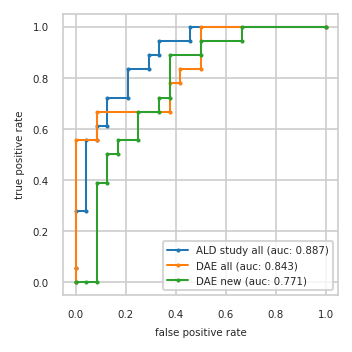

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.278   0.000 0.556   0.083 0.000
3          0.042 0.278   0.083 0.556   0.083 0.389
4          0.042 0.556   0.083 0.667   0.125 0.389
5          0.083 0.556   0.375 0.667   0.125 0.500
6          0.083 0.611   0.375 0.778   0.167 0.500
7          0.125 0.611   0.417 0.778   0.167 0.556
8          0.125 0.722   0.417 0.833   0.250 0.556
9          0.208 0.722   0.500 0.833   0.250 0.667
10         0.208 0.833   0.500 1.000   0.333 0.667
11         0.292 0.833   1.000 1.000   0.333 0.722
12         0.292 0.889     NaN   NaN   0.375 0.722
13         0.333 0.889     NaN   NaN   0.375 0.889
14         0.333 0.944     NaN   NaN   0.500 0.889
15         0.458 0.944     NaN   NaN   0.500 0.944
16         0.458 1.000     NaN   NaN   0.667 0.944
17         1.000 1.000     NaN   NaN   0.667 1.000
18           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,F5H265,Q96GD0,P01704
2,Q99969,Q86V85,P51688
3,P61981,P04075,P31321
4,P04075,Q9Y2T3;Q9Y2T3-3,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
5,P14174,P61981,Q9NUQ9
6,Q9Y2T3;Q9Y2T3-3,P15151-2,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
7,P00338;P00338-3,C9JF17;P05090,Q96GD0
8,C9JF17;P05090,P63104,A0A1W2PQ94;B4DS77;B4DS77-2;B4DS77-3


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


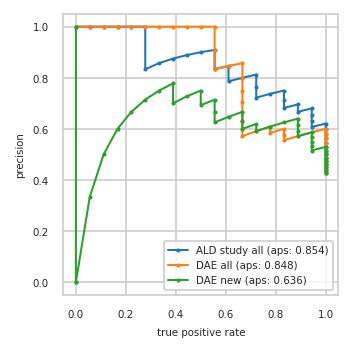

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.529 1.000
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.581 1.000     0.548 0.944
12         0.600 1.000     0.600 1.000     0.567 0.944
13         0.621 1.000     0.586 0.944     0.586 0.944
14         0.607 0.944     0.571 0.889     0.571 0.889
15         0.630 0.944     0.556 0.833     0.593 0.889
16         0.654 0.944     0.577 0.833     0.615 0.889
17         0.680 0.944     0.600 0.833     0.640 0.889
18         0.667 0.889     0.583 0.778     0.625 0.833
19         0.696 0.889     0.609 0.778     0.609 0.778
20         0.682 0.833     0.591 0.722     0.591 0.722
21         0.714 0.833     0.571 0.667     0.619 0.722
22         0.750 0.833     0.600 0.667     0.600 0.667
23         0.737 0.778     0.632 0.667     0.632 0.667
24         0.722 0.722     0.667 0.667     0.667 0.667
25         0.765 0.722     0.706 0.667     0.647 0.611
26         0.812 0.722     0.750 0.667     0.625 0.556
27         0.800 0.667     0.800 0.667     0.667 0.556
28         0.786 0.611     0.857 0.667     0.714 0.556
29         0.846 0.611     0.846 0.611     0.692 0.500
30         0.833 0.556     0.833 0.556     0.750 0.500
31         0.909 0.556     0.909 0.556     0.727 0.444
32         0.900 0.500     1.000 0.556     0.700 0.389
33         0.889 0.444     1.000 0.500     0.778 0.389
34         0.875 0.389     1.000 0.444     0.750 0.333
35         0.857 0.333     1.000 0.389     0.714 0.278
36         0.833 0.278     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


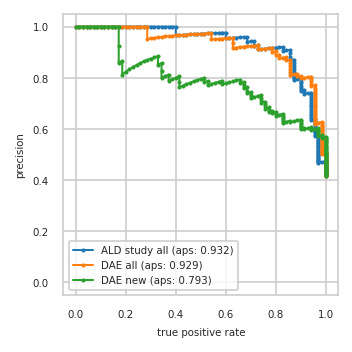

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


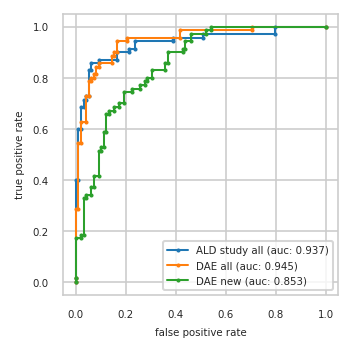

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}